In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm
import xarray as xr

from scipy import special

from utils import WGBP, LogisticFamily

random_seed = sum(map(ord, "gambia"))

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [3]:
df = pl.read_csv("gambia.csv")
df

x,y,pos,age,netuse,treated,green,phc
f64,i64,i64,i64,i64,i64,f64,i64
349631.3,1458055,1,1783,0,0,40.85,1
349631.3,1458055,0,404,1,0,40.85,1
349631.3,1458055,0,452,1,0,40.85,1
349631.3,1458055,1,566,1,0,40.85,1
349631.3,1458055,0,598,1,0,40.85,1
…,…,…,…,…,…,…,…
622086.1,1474011,1,1705,1,0,50.1,1
622086.1,1474011,1,1704,1,0,50.1,1
622086.1,1474011,1,1733,0,0,50.1,1


In [4]:
df_locations = df.select("x", "y").unique(maintain_order=True).with_columns(location=pl.row_index())
df = df.join(df_locations, on=["x", "y"])
df

x,y,pos,age,netuse,treated,green,phc,location
f64,i64,i64,i64,i64,i64,f64,i64,u32
349631.3,1458055,1,1783,0,0,40.85,1,0
349631.3,1458055,0,404,1,0,40.85,1,0
349631.3,1458055,0,452,1,0,40.85,1,0
349631.3,1458055,1,566,1,0,40.85,1,0
349631.3,1458055,0,598,1,0,40.85,1,0
…,…,…,…,…,…,…,…,…
622086.1,1474011,1,1705,1,0,50.1,1,64
622086.1,1474011,1,1704,1,0,50.1,1,64
622086.1,1474011,1,1733,0,0,50.1,1,64


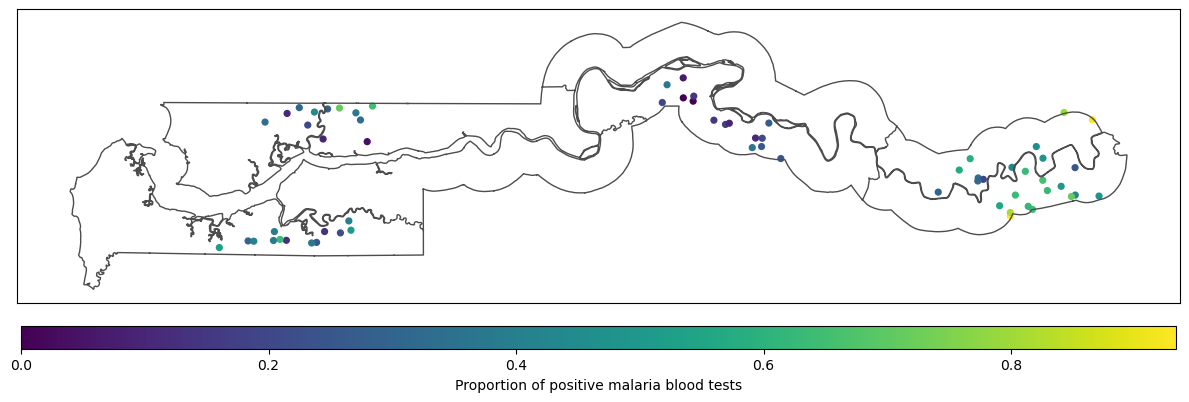

In [5]:
df_borders = pl.read_csv("gambia_borders.csv")

df_avg = (
    df.group_by("location")
    .agg(pl.col("pos").mean(), pl.col("x").first(), pl.col("y").first())
)

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df_borders["x"], df_borders["y"], color="0.3", lw=1)
points = ax.scatter(df_avg["x"], df_avg["y"], s=17.5, c=df_avg["pos"], cmap="viridis")

fig.colorbar(
    points,
    label="Proportion of positive malaria blood tests",
    ax=ax,
    pad=0.05,
    fraction=0.05,
    aspect=50,
    orientation="horizontal",
)
ax.set(xticks=[], yticks=[], aspect="equal");

In [6]:
def pl_scale(name):
    return (pl.col(name) - pl.col(name).mean()) / pl.col(name).std()

X_geo_std_unique = (
    df.with_columns(
        x_std=pl_scale("x"),
        y_std=pl_scale("y")
    )
    .select("x_std", "y_std")
    .unique(maintain_order=True)
    .to_numpy()
)

print(X_geo_std_unique.shape)
X_geo_std_unique[:5]

(65, 2)


array([[-1.41859375, -1.6756917 ],
       [-1.3288728 , -1.53945099],
       [-1.31110339, -1.54514701],
       [-1.27599142,  0.89837675],
       [-1.24976719, -1.53044334]])

In [7]:
# Compute pairwise squared distances
diff = X_geo_std_unique[:, None, :] - X_geo_std_unique[None, :, :] # shape (L, L, 2)
dist = np.sqrt(np.sum(diff**2, axis=-1))   # shape (L, L)
dist.shape

(65, 65)

## The model in the paper

### Model description

$$
\begin{aligned}
Y_i \mid \pi_i &\sim \text{Bernoulli}(\pi_i) \\
\text{logit}(\pi_i) = \eta_i &= \alpha + {\bf X}_i\boldsymbol\beta+\gamma_{g[i]} \\
\alpha &\sim \text{Normal}(\mu_0, \tau_0^2) \\
\boldsymbol{\beta} &\sim \text{Normal}(0, \frac{1}{5} \phi_1 W \mathbf{I})  \\
\boldsymbol{\gamma} &\sim \text{Normal}(0, \phi_2 W \mathbf{C}) \\
\rho &\sim \text{Uniform}(0, 2r) \\
W &\sim \text{GBP}(a^*, b^*, c^*, d^*) \\
(\phi_1, \phi_2) &\sim \text{Dirichlet}(\xi_1, \xi_2)
\end{aligned}
$$

we assume

$$
\begin{aligned}
\mathbb{E}(\gamma_i) &= 0 & \text{for all } i  \\
\mathbb{V}(\gamma_i) &= \sigma^2_\gamma & \text{for all } i \\
C_{ij} &= \text{Cor}(\gamma_i, \gamma_j) = e^{-d_{ij} / \rho} & \text{for all } i \ne j  \\
\end{aligned}
$$

where $d_{ij}$ is the distance between village $i$ and $j$, and $\rho > 0$ is the spatial range parameter.

* $\mu_0 = 0$
* $\tau_0^2 = 3$
* $\xi_1 = \xi_2 = 1$
* $r$ is the maximum distance between pairs of villages.

In [8]:
family = LogisticFamily(a=1, b=1, intercept=special.logit(df.get_column("pos").mean()))
params = WGBP(family)
params

array([1.36752202, 0.61766941, 0.82137832, 1.79821958])

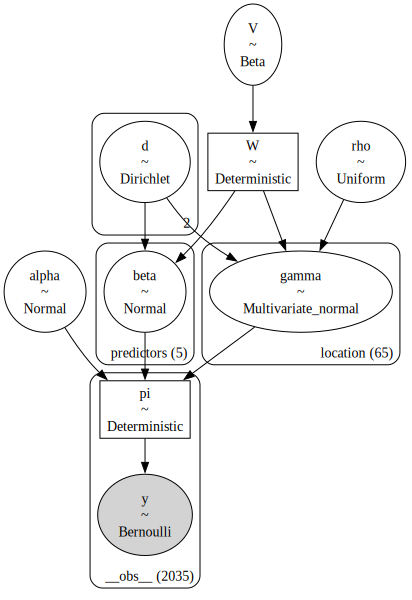

In [9]:
y = df.get_column("pos").to_numpy()
X = df.select("age", "netuse", "treated", "green", "phc").to_numpy()
X_std = (X - X.mean(0)) / X.std(0)
location_idx = df.get_column("location").to_numpy()

r = dist.max()  # Maximum distance
p = X.shape[1]  # Number of predictors
coords = {
    "__obs__": np.arange(len(y)),
    "predictors": ["age", "netuse", "treated", "green", "phc"],
    "location": np.unique(location_idx)
}

with pm.Model(coords=coords) as model:
    # Correlation matrix
    rho = pm.Uniform("rho", lower=0, upper=2 * r)
    C = np.exp(-dist / rho)

    V = pm.Beta("V", alpha=params[0], beta=params[1])
    W = pm.Deterministic("W", ((V / (1 - V)) ** (1 / params[2])) * params[3])

    d = pm.Dirichlet("d", a=np.ones(2))

    alpha = pm.Normal("alpha", mu=0, sigma=3 ** 0.5)
    beta = pm.Normal("beta", mu=0, sigma=((1 / p) * W * d[0]) ** 0.5, dims="predictors")

    gamma = pm.MvNormal("gamma", mu=0, cov=d[1] * W * C, dims="location")

    eta = alpha + X_std @ beta + gamma[location_idx]
    pi = pm.Deterministic("pi", pm.math.sigmoid(eta), dims="__obs__")

    pm.Bernoulli("y", p=pi, observed=y, dims="__obs__")

model.to_graphviz()

In [10]:
with model:
    idata = pm.sample(target_accept=0.9, draws=4000, random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, V, d, alpha, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


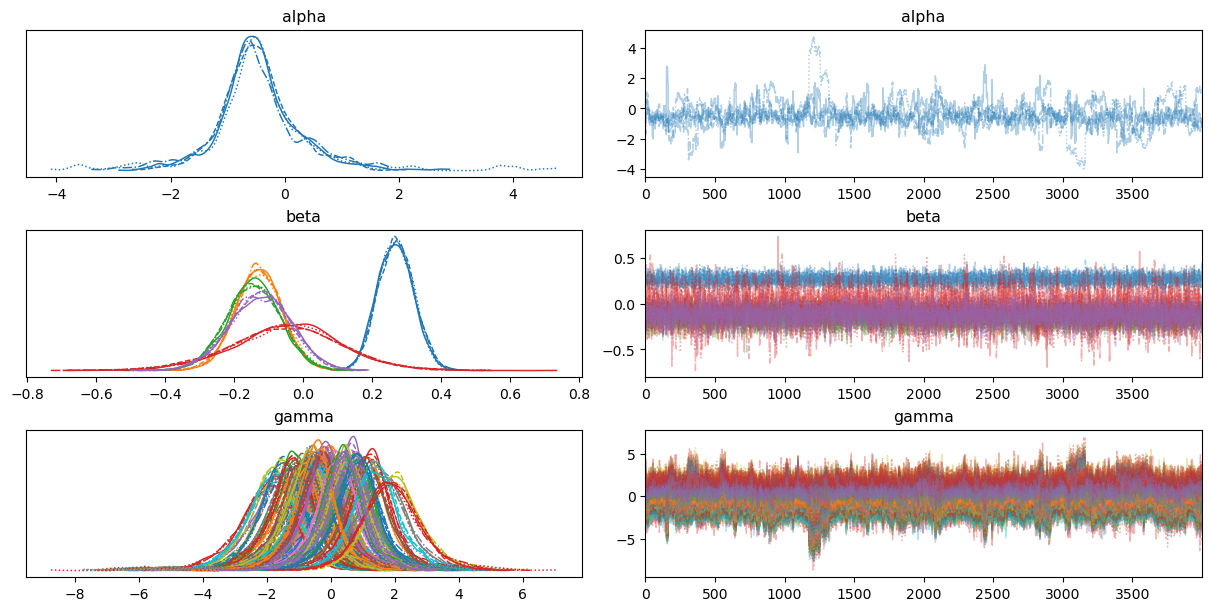

In [11]:
az.plot_trace(idata, var_names=["alpha", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

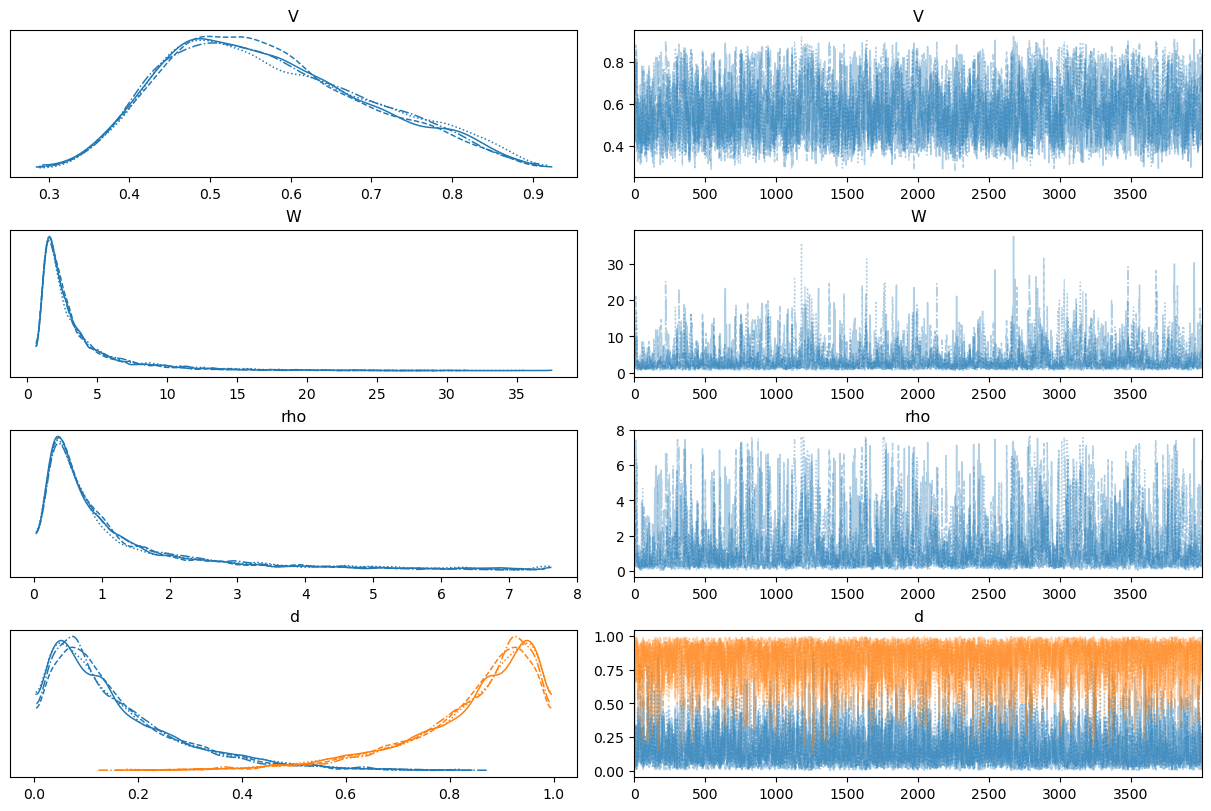

In [12]:
az.plot_trace(idata, var_names=["V", "W", "rho", "d"], backend_kwargs={"layout": "constrained"});

In [13]:
# TO DO: Add conditional R2

### A closer look

#### Priors are too wide

Sampling: [V, alpha, beta, d, gamma, rho, y]


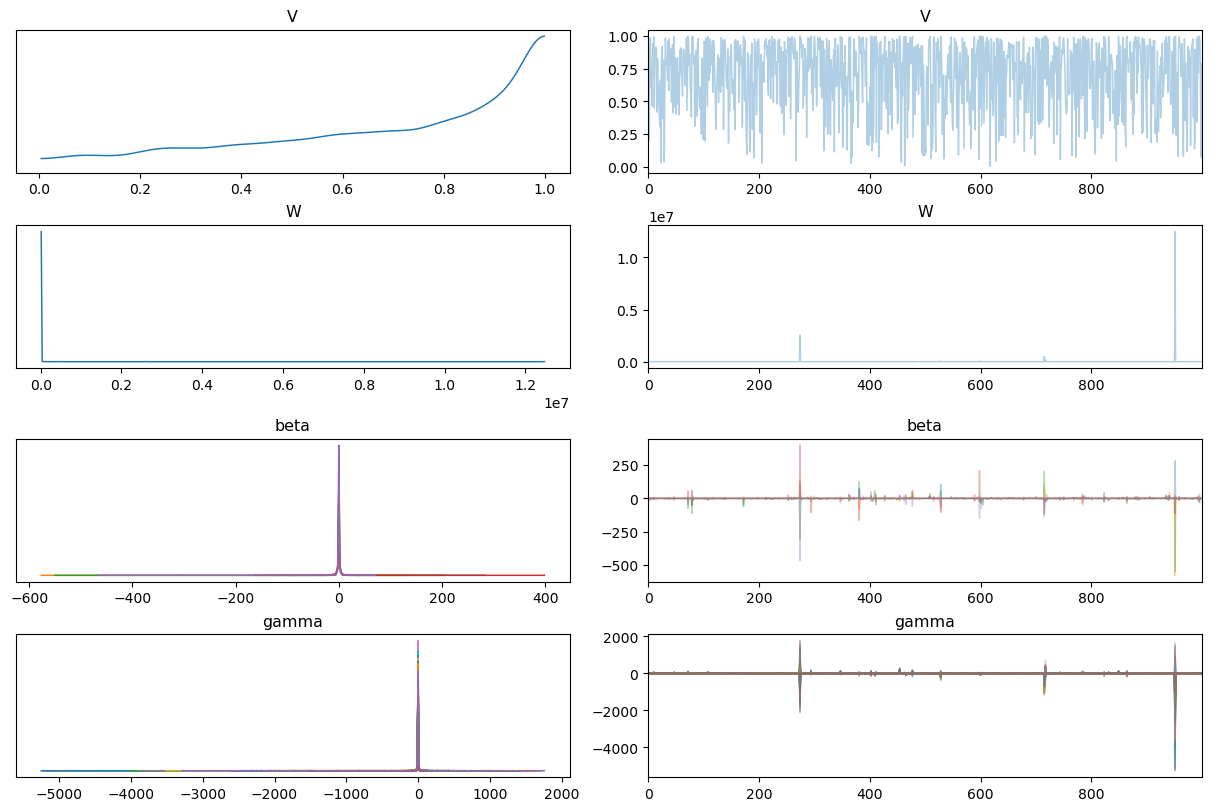

In [18]:
with model:
    idata.extend(pm.sample_prior_predictive(draws=1000, random_seed=random_seed))

az.plot_trace(idata.prior, var_names=["V", "W", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

#### Correlations between $\alpha$ and $\gamma_i$ are too large

In [19]:
np.sort(xr.corr(idata.posterior.gamma, idata.posterior.alpha, dim=("chain", "draw")))

array([-0.95220108, -0.94835147, -0.94309785, -0.93802749, -0.93443729,
       -0.93290634, -0.92990705, -0.92900007, -0.92859726, -0.92823639,
       -0.92798422, -0.92786087, -0.92266176, -0.92230996, -0.92185871,
       -0.92076629, -0.92062727, -0.9205165 , -0.91895014, -0.91852226,
       -0.9178261 , -0.91745498, -0.91467815, -0.91394068, -0.91296831,
       -0.91293467, -0.91252343, -0.91227221, -0.91008214, -0.90862995,
       -0.90819691, -0.90773414, -0.90506248, -0.90484818, -0.90435003,
       -0.90223466, -0.90192468, -0.90154432, -0.90151147, -0.89915502,
       -0.89598276, -0.89410248, -0.89096647, -0.88995653, -0.88806112,
       -0.88636287, -0.88419364, -0.88395102, -0.88386005, -0.881993  ,
       -0.88175332, -0.8810911 , -0.8793264 , -0.87734267, -0.86540643,
       -0.86168269, -0.85933536, -0.856284  , -0.8521011 , -0.84847545,
       -0.83497718, -0.82392561, -0.80815148, -0.79551536, -0.76744759])

#### Correlations between $\gamma_i$ and $\gamma_j$ are too large

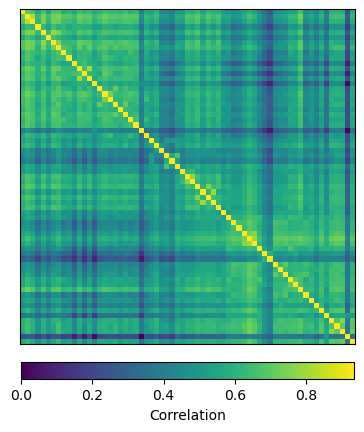

In [37]:
corr_matrix = np.corrcoef(idata.posterior.gamma.stack(sample=("chain", "draw")).to_numpy())

fig, ax = plt.subplots()
img = ax.imshow(corr_matrix);
fig.colorbar(
    points,
    label="Correlation",
    ax=ax,
    pad=0.05,
    fraction=0.045,
    orientation="horizontal",
)
ax.set(xticks=[], yticks=[], aspect="equal");

In [38]:
np.linalg.eigvals(corr_matrix)[:5]

array([52.66510786,  2.05953306,  0.54218027,  0.49678191,  0.38596075])

## An alternative proposal

In [40]:
family = LogisticFamily(a=2, b=8, intercept=special.logit(df.get_column("pos").mean()))
params_2 = WGBP(family)
params_2

array([3.45220389, 6.72368657, 0.72156864, 2.96020658])

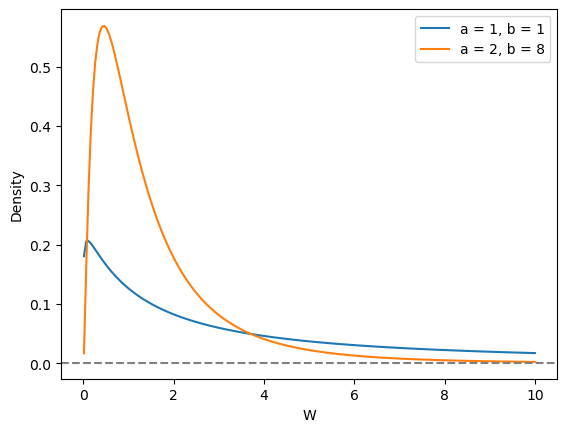

In [41]:
from utils import gbp_pdf

params_dict = {
    "a = 1, b = 1":   params,
    "a = 2, b = 8":   params_2,
}

fig, ax = plt.subplots()
x_grid = np.linspace(0.01, 10, num=200)

for key, values in params_dict.items():
    ax.plot(x_grid, gbp_pdf(x_grid, *values), label=key)

ax.axhline(0, ls="--", color="0.5")
ax.set(xlabel="W", ylabel="Density")
ax.legend();

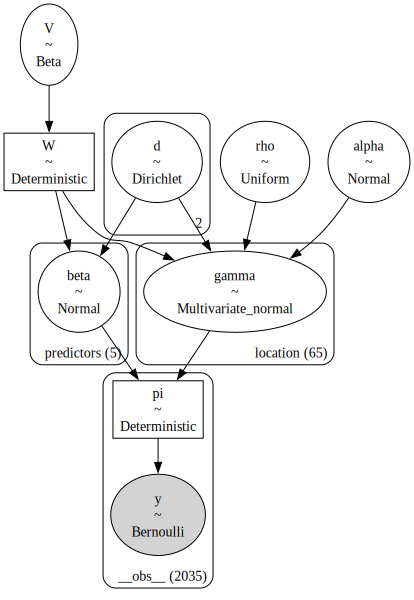

In [42]:
coords = {
    "__obs__": np.arange(len(y)),
    "predictors": ["age", "netuse", "treated", "green", "phc"],
    "location": np.unique(location_idx)
}

with pm.Model(coords=coords) as model_2:
    # Correlation matrix
    rho = pm.Uniform("rho", lower=0, upper=2 * r)
    C = np.exp(-dist / rho)

    V = pm.Beta("V", alpha=params_2[0], beta=params_2[1])
    W = pm.Deterministic("W", (V / (1 - V)) ** (1 / params_2[2]) * params_2[3])
    d = pm.Dirichlet("d", a=np.ones(2))

    alpha = pm.Normal("alpha", mu=0, sigma=0.5** 0.5)
    beta = pm.Normal("beta", mu=0, sigma=(1 / p * W * d[0]) ** 0.5, dims="predictors")

    gamma = pm.MvNormal("gamma", mu=alpha, cov=d[1] * W * C, dims="location")

    eta = X_std @ beta + gamma[location_idx]
    pi = pm.Deterministic("pi", pm.math.sigmoid(eta), dims="__obs__")

    pm.Bernoulli("y", p=pi, observed=y, dims="__obs__")

model_2.to_graphviz()

Sampling: [V, alpha, beta, d, gamma, rho, y]


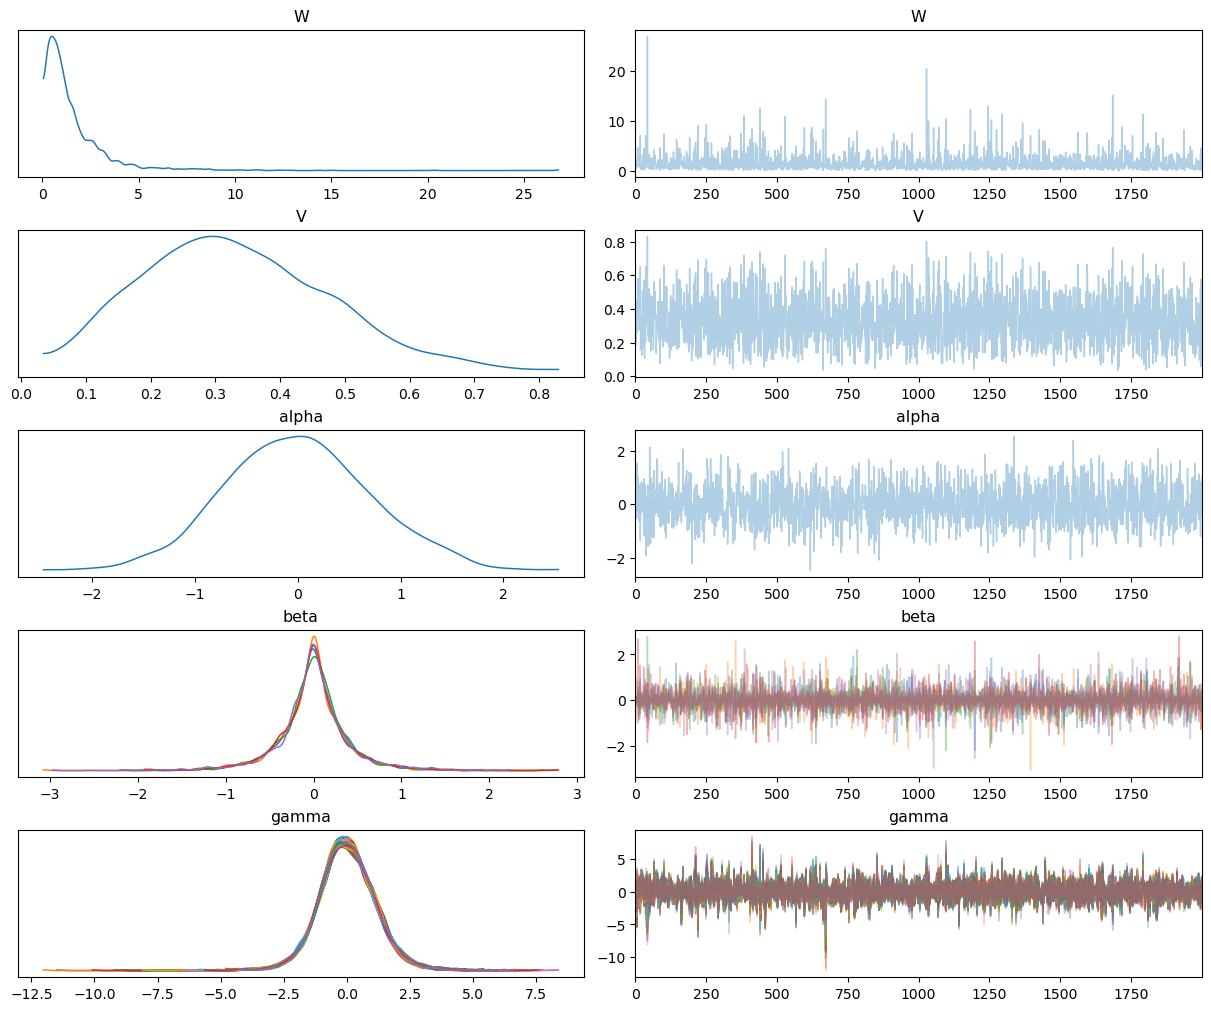

In [43]:
with model_2:
    idata_2 = pm.sample_prior_predictive(draws=2000, random_seed=random_seed)

az.plot_trace(idata_2.prior, var_names=["W", "V", "alpha", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

In [53]:
with model_2:
    idata_2.extend(pm.sample(random_seed=random_seed))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, V, d, alpha, beta, gamma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


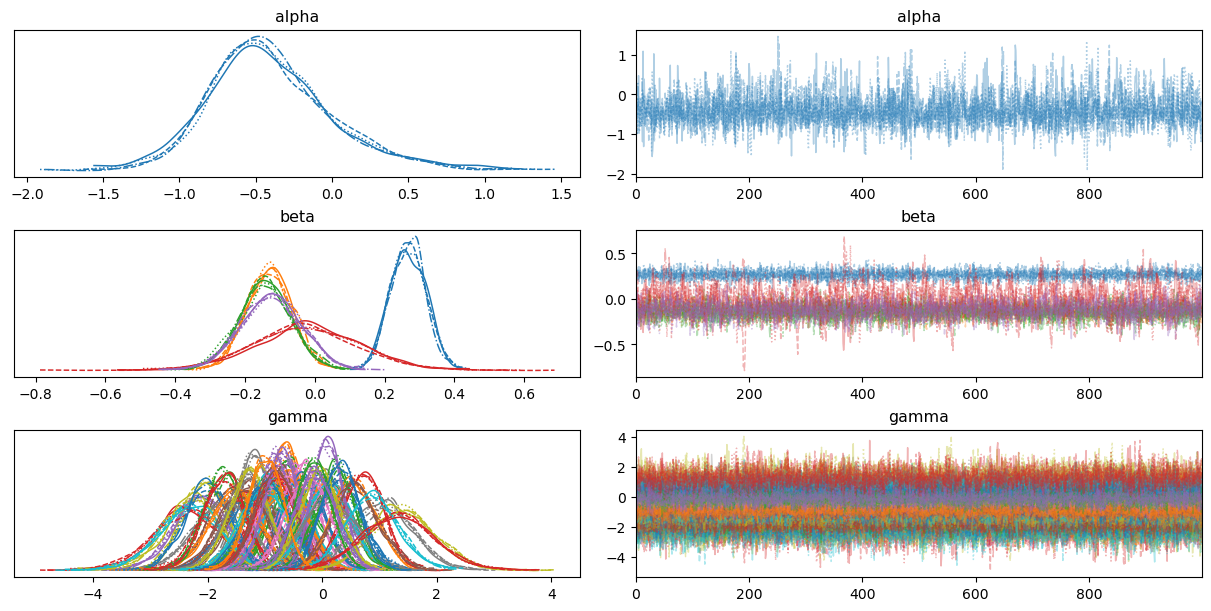

In [54]:
az.plot_trace(idata_2, var_names=["alpha", "beta", "gamma"], backend_kwargs={"layout": "constrained"});

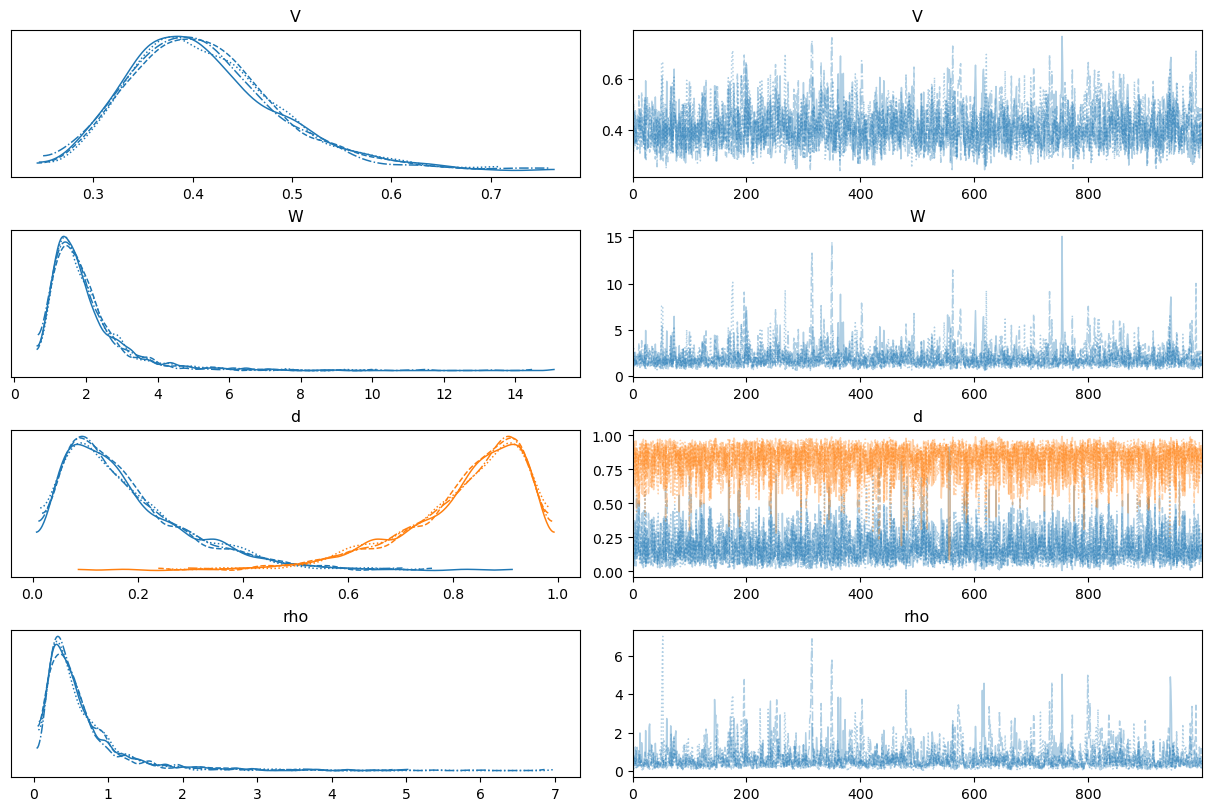

In [55]:
az.plot_trace(idata_2, var_names=["V", "W", "d", "rho"], backend_kwargs={"layout": "constrained"});

In [56]:
np.sort(xr.corr(idata_2.posterior.gamma, idata_2.posterior.alpha, dim=("chain", "draw")))

array([-0.15312088, -0.11929836, -0.10515476, -0.08473335, -0.08389891,
       -0.08071595, -0.08026213, -0.08017609, -0.07472148, -0.07119663,
       -0.06429261, -0.06337483, -0.05653138, -0.04991921, -0.0468516 ,
       -0.04025684, -0.03805533, -0.03445069, -0.03291856, -0.02652071,
       -0.02594216, -0.01819967, -0.01170555, -0.01061647, -0.01043557,
       -0.00973183, -0.00122462,  0.00068456,  0.00117068,  0.00333116,
        0.00347231,  0.00889756,  0.01052275,  0.01091672,  0.01491479,
        0.01735002,  0.02330452,  0.02584276,  0.02870033,  0.04000509,
        0.04562353,  0.04735007,  0.05122122,  0.0537449 ,  0.05555512,
        0.06132793,  0.06390431,  0.06970725,  0.07019799,  0.07155107,
        0.0716909 ,  0.07238494,  0.07318959,  0.07648728,  0.08240382,
        0.08570036,  0.08979539,  0.09656979,  0.0975695 ,  0.10000723,
        0.10752308,  0.11348371,  0.11627793,  0.11978045,  0.18105575])

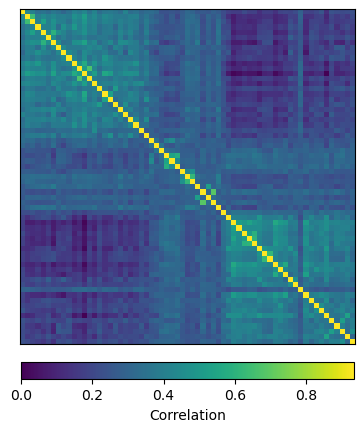

In [57]:
corr_matrix = np.corrcoef(idata_2.posterior.gamma.stack(sample=("chain", "draw")).to_numpy())

fig, ax = plt.subplots()
img = ax.imshow(corr_matrix);

fig.colorbar(
    points,
    label="Correlation",
    ax=ax,
    pad=0.05,
    fraction=0.045,
    orientation="horizontal",
)
ax.set(xticks=[], yticks=[], aspect="equal");

In [58]:
np.tril(corr_matrix, k=-1).min(), np.tril(corr_matrix, k=-1).max()

(np.float64(-0.42375350954597935), np.float64(0.6283368533849049))

In [59]:
np.linalg.eigvals(corr_matrix)

array([10.07277474,  2.49138056,  2.19045136,  1.92965213,  1.66784676,
        1.62952418,  1.51892208,  1.4227175 ,  1.33726177,  1.30522099,
        1.23164122,  1.20875491,  1.17150195,  1.12988473,  1.10593187,
        1.09611328,  1.07633178,  1.0106391 ,  0.99886946,  0.98253392,
        0.33671727,  0.34666218,  0.94869024,  0.36811542,  0.93073779,
        0.91878398,  0.90645707,  0.38521105,  0.39205022,  0.883567  ,
        0.86590037,  0.8597574 ,  0.84047552,  0.41791851,  0.42495036,
        0.43924924,  0.45034791,  0.81014244,  0.80077937,  0.78336138,
        0.47580634,  0.48224671,  0.4962546 ,  0.50513079,  0.76013615,
        0.52622562,  0.53290523,  0.54529032,  0.55177177,  0.56183111,
        0.57325936,  0.58635096,  0.5979212 ,  0.60366817,  0.61108627,
        0.74171984,  0.73551079,  0.63872214,  0.65338083,  0.65785749,
        0.71439197,  0.708419  ,  0.69480495,  0.67836785,  0.67911152])

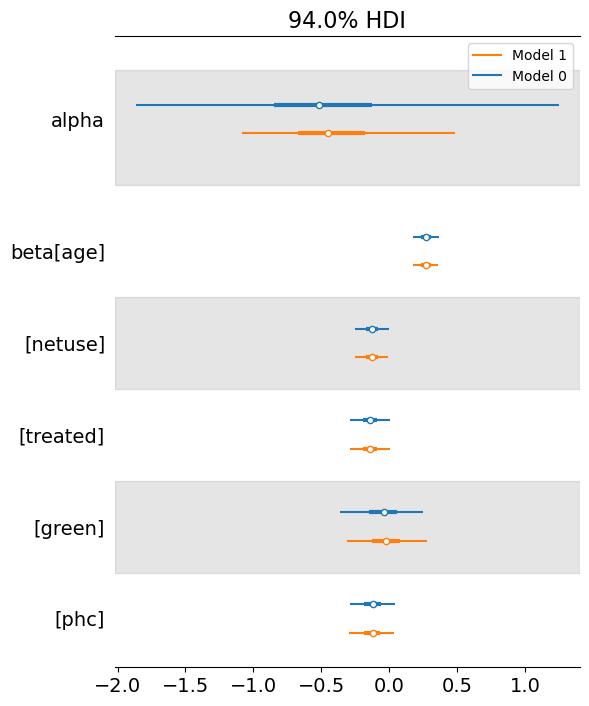

In [60]:
az.plot_forest([idata, idata_2], var_names=["alpha", "beta"], combined=True);

In [ ]:
az.plot_forest([idata, idata_2], var_names="gamma", combined=True);